<a href="https://colab.research.google.com/github/Rajnish-TheGreat/audioCompare/blob/main/audioComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [282]:
"""
IMPORTS
"""

import pdb

import librosa
from librosa.feature import chroma_stft
import librosa.display

import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import seaborn as sns

"""
AUDIO ANALYZER CLASS
==========================================================================================================
"""

class AudioAnalyzer:
    
    def __init__(self, filename, fft_size=256, input_sr=41000, analyze=True):
        """
        Loads in and transform sample data from an audio file into a pandas dataframe for analysis and graphing
        
        Input: 
            filename: relative path to audio file
            fft_size: The number of frequency bins for the fft analysis. Defaults to 256
            input_sr: the sample rate of the input audio file. Defaults to 41000
        """
        y, sr = librosa.load(filename, sr=input_sr)
        self.y = y
        self.sr = sr
        self.fft_size = fft_size
        if analyze:
            self.spectrum_analysis()
        
    def change_fft_bin_size(self, size):
        """
           Optionally changes the number of fft bins after initialization.
        """
        self.fft_size = size
        self.spectrum_analysis()
        
    def spectrum_analysis(self):
        """
        Runs spectrum analysis on the input audio file. Sets and returns a dataframe with frequency information across all fft bins. 
        Amplitudes are averaged at each frequency.
        Note: This method must be called before any analysis or plotting can be done on the class instance. 
        """
        self.df = pd.DataFrame(np.abs(librosa.stft(self.y, n_fft=self.fft_size)))
        
        bins = librosa.fft_frequencies(sr=self.sr, n_fft=self.fft_size)
        
        self.df['bins'] = bins / 1000. # divide by 1000 lets us display in kHz
        
        self.df['average_amplitude'] = self.df.mean(axis=1)
        self.df = self.df[['bins', 'average_amplitude']]
        return self.df
    
    def plot_spectrum(self, min_freq=0, max_freq=None, fill=False, title="Spectrogram - Average Frequency"):
        
        """
        Plots a single spectrogram of averaged frequencies across all fft bins. Uses the generated dataframe as the source. 
        """
        
        max_freq = max_freq or 20000.
        window = self.df.loc[(self.df.bins * 1000. >= min_freq) & (self.df.bins * 1000. <= max_freq)].copy()
        window['scaled_amplitude'] = np.interp(window.average_amplitude, (0., max(window.average_amplitude)), (0., 1.))
        window.plot(x='bins', y='scaled_amplitude', figsize=(16,4))
        if fill:            
            plt.fill_between(self.df.bins, self.df.average_amplitude)
        
        legend = plt.legend()
        legend.remove()
        plt.xlabel("Frequency (kHz)", fontsize=20)
        plt.ylabel("Amplitude (scaled)", fontsize=20)
        plt.title(title, fontsize=26)



"""
SIGNAL COMPARE CLASS
==========================================================================================================
"""        
        
        
class SpectrumCompare():
    
    def __init__(self, original, modified):
        """
        Compares the frequency and amplitude information of two AudioAnalyzer class instances. 
        
        Input:
            original, modified: the two AudioAnalyzer class instances.
        """
        self.original_df = original.df
        self.modified_df = modified.df
        
        self.dfs = [self.original_df, self.modified_df]
        
        self.get_max_average(self)
        self.scale_amplitudes(self)
        self.get_ratio_df(self)
    
    def plot_spectrum_group(self,
                            spec_1=True,
                            spec_2=True,
                            title="Comparison of Frequency Amplitudes",
                            xlabel="Frequency (kHz)",
                            ylabel="Scaled Amplitude",                             
                            frange=None,
                            ratio=False,
                            legend=["Spectrum 1", "Spectrum 2", "Signal Diff.", "Threshold"],
                            threshold=False,
                          
                           ):
        """
        Plots a spectrogram comparing the frequencies and relative amplitudes at each fft bin of the two AudioAnalyzer class instances. 
        Plots up to four lines:
            first AudioAnalyzer class instance - frequency and amplitude
            Second AudioAnalyzer class instance - frequency and amplitude
            Difference in amplitude at each bin
            Threshold - Shows where the first or second AudioAnlyzer amplitude is greater (relative hot or old spots)
        """
        
        dfs = self.dfs.copy()
        fig = plt.figure(figsize=(16,8))
        
        if frange:
            for i, df in enumerate(dfs):
                dfs[i] = df.loc[(df.bins * 1000. >= frange[0]) & (df.bins * 1000. <= frange[1])]
        else:
            dfs = self.dfs
        
        
        if spec_1: plt.plot(dfs[0].bins, dfs[0].scaled_amplitude, label=legend[0], c="steelblue")
        if spec_2: plt.plot(dfs[1].bins, dfs[1].scaled_amplitude, label=legend[1], c="coral")

        if ratio:
            if frange:                
                ratio_df = self.ratio_df[(self.ratio_df.bins * 1000. >= frange[0]) & (self.ratio_df.bins * 1000. <= frange[1])]
                plt.plot(ratio_df['bins'], ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen", linestyle="-.")
            else:
                plt.plot(self.ratio_df['bins'], self.ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen")
        
        if threshold and frange:
            plt.plot([frange[0] / 1000, frange[1] / 1000], [0.5, 0.5], linestyle="--", label=legend[3], c="r")
        
        plt.title(title, fontsize=24)
        plt.xlabel(xlabel, fontsize=20)
        plt.ylabel(ylabel, fontsize=20) 
        plt.legend(fontsize=14)
        return dfs
        
    def plot_spectrum_heatmap(self, 
                               plot_spec1=True,
                               frange=[], 
                               title="Audio Comparison", 
                               cmap="plasma",
                               background_color="white",
                               background_alpha=0.5
                              ):
        """
        Plots a heatmap and spectrogram showing the relative hot and cool spots of thw two compared AudioAnalyzer class instances. 
        A number of options are available to customize the appearance of the generated plot. 
        """
        
#       DATAFRAME SETUP
        if plot_spec1:
            df = self.original_df
        else:
            df = self.modified_df            

        df['ratio_amplitude'] = self.ratio_df.scaled_amplitude

        df['attenuated_scaled'] = df.scaled_amplitude
        df['boosted_scaled'] = df.scaled_amplitude
        
        if len(frange):
            plot_df = df.loc[(df.bins >= frange[0] / 1000) & (df.bins <= frange[1] / 1000)]
            ratio_df = self.ratio_df.loc[(self.ratio_df.bins >= frange[0] / 1000) & (self.ratio_df.bins <= frange[1] / 1000)] 
        else:
            plot_df = df
            ratio_df = self.ratio_df
        
#       FIGURE SETUP
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(211, facecolor="white")
        # ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, facecolor="white", fig=fig)
        ax2 = fig.add_subplot(211, facecolor="#00000000")
        # ax2 = plt.subplot2grid((8,1), (0,0), rowspan=2, facecolor="#00000000", fig=fig)
        # fig2 = plt.figure(figsize=(32, 8))
        # cbaxes = fig2.add_subplot(32,1,1) 
        cbaxes = plt.subplot2grid((16,1), (10,0)) 
        cbaxes.set_title("Scaled Amplitude Ratio", size=14)
        
#       HEATMAP PLOT
        sns.heatmap(data=ratio_df.set_index('bins').transpose(), cbar=True, cbar_ax=cbaxes, cbar_kws={"orientation" : "horizontal"}, cmap=cmap, alpha=0.95, zorder=1, ax=ax1, vmin=0.0, vmax=1.0)
        ax1.set_xlabel("")
        ax1.set_xticks([])
        ax1.set_ylabel("")
        ax1.set_yticks([])

#       FREQUENCY PLOT        
        sns.lineplot(data=plot_df, x="bins", y="scaled_amplitude", color='black', zorder=10, ax=ax2, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
        ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, color='white', alpha=0.0)
        ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, y2=1.0, color=background_color, alpha=background_alpha)

        ax2.set_xlabel("Frequency (kHz)", size=28)
        ax2.set_ylabel("Scaled Amplitude", size=28)     
        
        ax2.margins(0)
        fig.suptitle(title, size=36, y=0.95)
        return pd.DataFrame(data=plot_df)
    
    def plot_amplitude_distributions(self, 
                                    n=10000, 
                                    size=1000,
                                    title="Amplitude Distributions",
                                    xlabel="Average Amplitude (unscaled)",
                                    ylabel="Density"
                                    ):
        amp1 = self.dfs[0].scaled_amplitude
        amp2 = self.dfs[1].scaled_amplitude

        samples_1 = []
        samples_2 = []

        for i in range(size):
            samples_1.append(np.random.choice(amp1, size=size).mean())
            samples_2.append(np.random.choice(amp2, size=size).mean())

        plt.figure(figsize=(8,6))

        sns.distplot(samples_1)
        sns.distplot(samples_2)

        plt.title(title, fontsize=18)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)

        t_stat, p_val = ttest_ind(samples_1, samples_2, equal_var=False)
        return pd.DataFrame([[t_stat, p_val]], columns=["T-Statistic", "P-Value"])


    @staticmethod
    def get_max_average(self):
        max_average = 0
        for df in self.dfs:
            cur_max = df.average_amplitude.max()
            max_average = cur_max if cur_max > max_average else max_average
        
        self.max_average = max_average
    
    @staticmethod
    def scale_amplitudes(self):        
        scaled_dfs = []
        for df in self.dfs:
            averaged = df['average_amplitude']
            df['scaled_amplitude'] = np.interp(averaged, (0., self.max_average), (0., 1.)) 
            scaled_dfs.append(df)            
        self.original_df, self.modified_df = scaled_dfs
        
    @staticmethod
    def get_ratio_df(self):
        
        orig_scaled = self.original_df.scaled_amplitude
        mod_scaled = self.modified_df.scaled_amplitude
        
        self.ratio_df = pd.DataFrame((mod_scaled - orig_scaled) + 0.5)
        self.ratio_df['bins'] = self.original_df.bins
        
        self.ratio_df.loc[self.ratio_df.scaled_amplitude > 1.0, ['scaled_amplitude']] = 1.0
        self.ratio_df.loc[self.ratio_df.scaled_amplitude < 0.0, ['scaled_amplitude']] = 0.0

In [283]:
import time 
time_start = time.time()
a = AudioAnalyzer("guitar1.mpeg")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [284]:
b = AudioAnalyzer("guitar2.mpeg")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [285]:
c = SpectrumCompare(a,b)

,bins,average_amplitude,scaled_amplitude,ratio_amplitude,attenuated_scaled,boosted_scaled
0,0.000000,6.045594,0.570829,0.582068,0.570829,0.570829
1,0.160156,9.806274,0.925915,0.574085,0.925915,0.925915
2,0.320312,8.508127,0.803343,0.528799,0.803343,0.803343
3,0.480469,3.643975,0.344067,0.539663,0.344067,0.344067
4,0.640625,1.851817,0.174850,0.511888,0.174850,0.174850
...,...,...,...,...,...,...
124,19.859375,0.003061,0.000289,0.500005,0.000289,0.000289
125,20.019531,0.003082,0.000291,0.500005,0.000291,0.000291
126,20.179688,0.003127,0.000295,0.500005,0.000295,0.000295
127,20.339844,0.003144,0.000297,0.500005,0.000297,0.000297


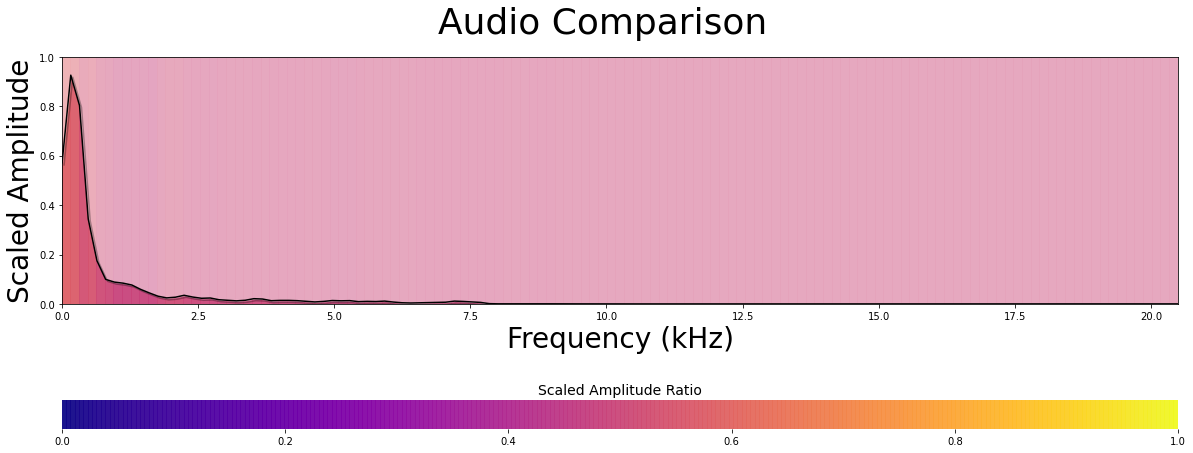

In [286]:
c.plot_spectrum_heatmap()

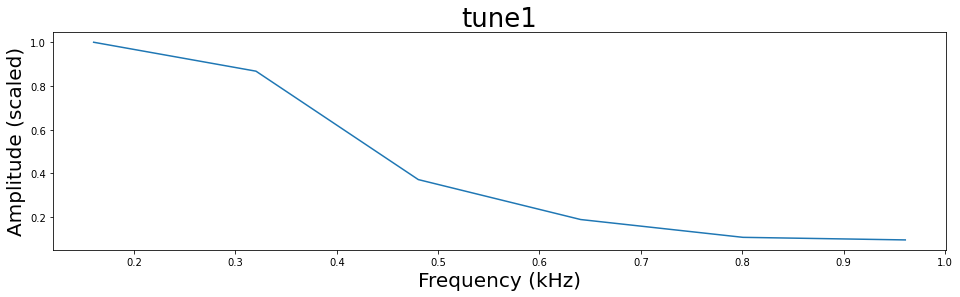

In [287]:
a.plot_spectrum(min_freq=20, max_freq=1000, title="tune1")

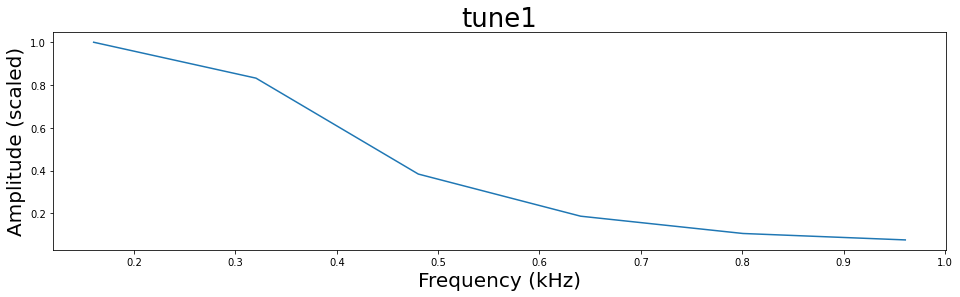

In [288]:
b.plot_spectrum(min_freq=20, max_freq=1000, title="tune1")

[       bins  average_amplitude  ...  attenuated_scaled  boosted_scaled
 0  0.000000           6.045594  ...           0.570829        0.570829
 1  0.160156           9.806274  ...           0.925915        0.925915
 2  0.320312           8.508127  ...           0.803343        0.803343
 3  0.480469           3.643975  ...           0.344067        0.344067
 4  0.640625           1.851817  ...           0.174850        0.174850
 5  0.800781           1.052861  ...           0.099412        0.099412
 6  0.960938           0.937132  ...           0.088485        0.088485
 
 [7 rows x 6 columns],        bins  average_amplitude  scaled_amplitude
 0  0.000000           6.914771          0.652897
 1  0.160156          10.590899          1.000000
 2  0.320312           8.813135          0.832142
 3  0.480469           4.064044          0.383730
 4  0.640625           1.977722          0.186738
 5  0.800781           1.121629          0.105905
 6  0.960938           0.803054          0.075825]

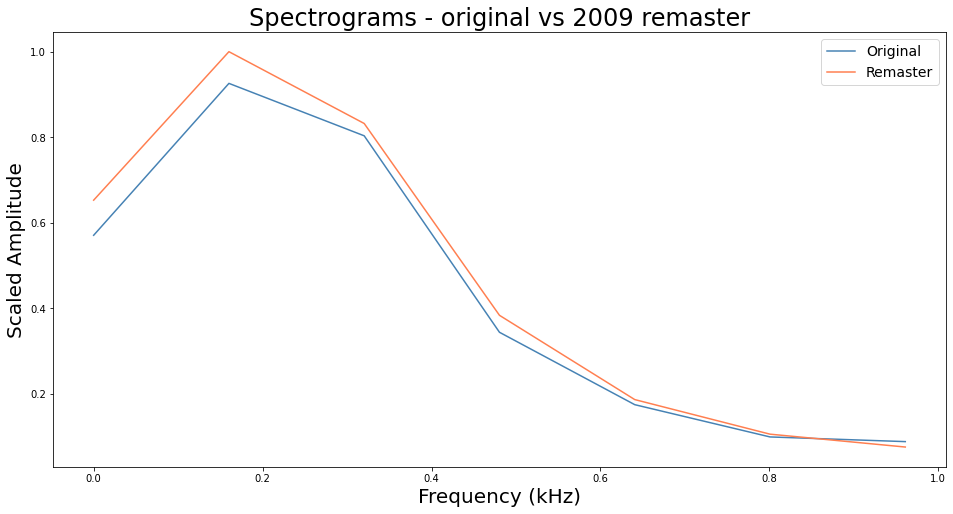

In [319]:
c.plot_spectrum_group(
    frange=(0,1000), 
    title="Spectrograms - original vs 2009 remaster", 
    legend=("Original", "Remaster")
    )

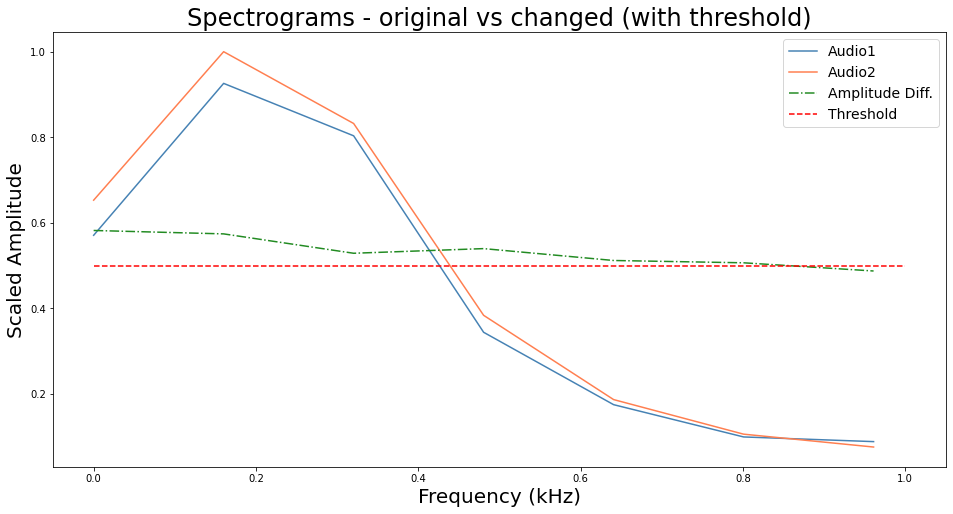

In [290]:
avg_amp = c.plot_spectrum_group(
    frange=(0,1000), 
    ratio=True, 
    threshold=True,
    # spec_1=False,
    # spec_2=False,
    title="Spectrograms - original vs changed (with threshold)", 
    legend=("Audio1", "Audio2", "Amplitude Diff.", "Threshold")
    )

In [291]:
 y, _ = librosa.load("guitar1.mpeg",sr=None)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [292]:
y

array([ 0.        ,  0.        ,  0.        , ..., -0.00283813,
       -0.00248718, -0.00183105], dtype=float32)

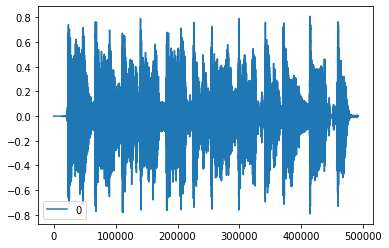

In [293]:
pd.DataFrame(data=y).plot()

In [294]:
 y2, _ = librosa.load("guitar2.mpeg",sr=None)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


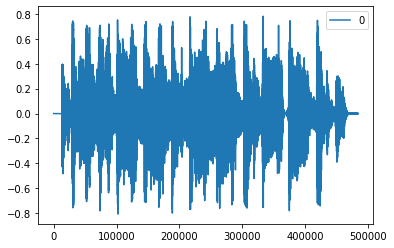

In [295]:
pd.DataFrame(data=y2).plot()

In [296]:
y.shape

(491520,)

In [297]:
y2.shape
from copy import copy

In [298]:
y_new_1 = copy(y[:min(y.shape[0],y2.shape[0])])

In [299]:
y_new_2 = copy(y2[:min(y.shape[0],y2.shape[0])])

In [300]:
y_diff = y_new_1 - y_new_2


In [301]:
y_diff_1 = pd.DataFrame(data=y_diff)

In [324]:
y_diff_1

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
483835,0.000488
483836,0.000809
483837,0.001266
483838,0.001953


In [302]:
avg_amp[0]['average_amplitude']

0    6.045594
1    9.806274
2    8.508127
3    3.643975
4    1.851817
5    1.052861
6    0.937132
Name: average_amplitude, dtype: float64

In [303]:
avg_amp[1]['average_amplitude']

0     6.914771
1    10.590899
2     8.813135
3     4.064044
4     1.977722
5     1.121629
6     0.803054
Name: average_amplitude, dtype: float64

In [304]:
10/7

1.4285714285714286

In [305]:
diff = avg_amp[0]['average_amplitude'] - avg_amp[1]['average_amplitude']

In [306]:
diff

0   -0.869176
1   -0.784625
2   -0.305008
3   -0.420069
4   -0.125905
5   -0.068768
6    0.134078
Name: average_amplitude, dtype: float64

In [307]:

time_end = time.time()

In [309]:
for idx,val in enumerate(diff):
  if abs(val) >=0 and abs(val) <=0.3: 
    print(True,idx)
  else:
    print(False,round(idx*1.4,2))



False 0.0
False 1.4
False 2.8
False 4.2
True 4
True 5
True 6


In [325]:
# filename = librosa.load("guitar1")

filename = "guitar1.mpeg"
# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Estimated tempo: 136.00 beats per minute


In [328]:
def get_beats(filename=None):
  if filename:
    y,sr =librosa.load(filename)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    return beat_times 
  raise Exception("filename not provided")

In [366]:
g1= get_beats("guitar1.mpeg")
g2  = get_beats("guitar2.mpeg")
filename = librosa.example('nutcracker')
g3 = get_beats(filename)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Estimated tempo: 136.00 beats per minute


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Estimated tempo: 66.26 beats per minute
Estimated tempo: 107.67 beats per minute


In [367]:
g2 = g2.tolist()
g1= g1.tolist()
g3 = g3.tolist()

In [368]:
for i in range(len(g3)): 
  try: 
    val = abs(round(g3[i]-g2[i],3))
    if val > 0.1:
      print(i+1,round(g3[i],3))
  except Exception as e:
    print("BEAT COUNT MISMATCH")
    break
    


1 1.184
2 1.718
3 2.322
4 2.879
5 3.46
6 4.017
7 4.598
8 5.132
BEAT COUNT MISMATCH


In [361]:
g1

[0.06965986394557823,
 0.5108390022675737,
 0.9984580498866213,
 1.4396371882086167,
 1.9040362811791383,
 2.345215419501134,
 2.8792743764172335,
 3.3901133786848074,
 3.8312925170068026,
 4.295691609977324,
 4.73687074829932,
 5.340589569160998,
 5.804988662131519,
 6.246167800453515,
 6.710566893424036,
 7.151746031746032,
 7.75546485260771,
 8.219863945578231,
 8.6378231292517]

In [362]:
g2

[0.301859410430839,
 1.1145578231292517,
 2.136235827664399,
 3.0418140589569163,
 3.8080725623582765,
 4.551111111111111,
 5.433469387755102,
 6.339047619047619]

In [369]:
g3

[1.18421768707483,
 1.7182766439909296,
 2.3219954648526078,
 2.8792743764172335,
 3.4597732426303853,
 4.017052154195011,
 4.597551020408163,
 5.131609977324263,
 5.735328798185941,
 6.292607709750567,
 6.849886621315193,
 7.4071655328798185,
 7.987664399092971,
 8.544943310657596,
 9.125442176870749,
 9.659501133786849,
 10.216780045351474,
 10.727619047619047,
 11.284897959183674,
 11.795736961451247,
 12.329795918367347,
 12.863854875283447,
 13.421133786848072,
 13.955192743764172,
 14.489251700680272,
 15.023310657596372,
 15.557369614512472,
 16.091428571428573,
 16.62548752834467,
 17.159546485260773,
 17.69360544217687,
 18.250884353741498,
 18.808163265306124,
 19.319002267573698,
 19.87628117913832,
 20.387120181405894,
 20.921179138321996,
 21.455238095238094,
 21.989297052154196,
 22.523356009070294,
 23.057414965986396,
 23.591473922902495,
 24.125532879818593,
 24.659591836734695,
 25.193650793650793,
 25.727709750566895,
 26.261768707482993,
 26.81904761904762,
 27.3531

In [370]:
!pip install aubio


     |████████████████████████████████| 481kB 8.3MB/s 
  Created wheel for aubio: filename=aubio-0.4.9-cp37-cp37m-linux_x86_64.whl size=390029 sha256=b7eb8972ac2571f591e2b88b1a833645c0d84b9d39c2535fa92a1d914f513f9a
  Stored in directory: /root/.cache/pip/wheels/ac/93/da/33a0041dff56d6c1faf82c83ff487cf669442b7087db20a995
Successfully built aubio


In [ ]:
-